In [89]:
import pyterrier as pt
import matplotlib.pyplot as plt
from os import listdir
from os.path import join, isdir
import sys
if not pt.started():
    pt.init()

In [90]:
def qrles_trec(path):
    
    filein = path+"/CISI.REL"
    fileout= open("qrels_CISI", "x",encoding='utf-8')
    with open(filein,'r',encoding='utf-8') as f:  
        for line in f.readlines():
            query_id, document_id, _,_ = line.split()
            fileout.write("{} {} {} {}\n".format(query_id, 0, document_id, 1))
    fileout.close()


In [91]:
path = 'cisi' #sys.argv[1]
qrles_trec(path)

In [92]:
def procesar_archivo_all(path):
    path = path + '/CISI.ALL'
    with open(path, 'r', encoding='utf-8') as file:
        contenido = file.read()
    
    # Dividir el contenido en documentos
    documentos = contenido.split(".I ")[1:]
    
    # Escribir cada documento en el archivo de salida en formato TREC
    with open('archivo_salida.trec', 'w', encoding='utf-8') as file:
        for i, documento in enumerate(documentos, start=1):
            # Agregar etiquetas TREC
            documentoTrec = "<DOC>\n<DOCNO>" + str(i) + "</DOCNO>\n" + documento.strip() + "\n</DOC>\n\n"
            file.write(documentoTrec)

In [93]:
procesar_archivo_all(path)

In [94]:
import re
import nltk
from nltk.corpus import stopwords as nltk_stopwords

# Descargar las stopwords de NLTK si no están disponibles
nltk.download('stopwords')

# Expresión regular para eliminar caracteres no alfanuméricos
regex_alpha_words = re.compile(r'[^a-zA-Z0-9áéíóúÁÉÍÓÚüÜñÑ]')

# Lista de stopwords de NLTK
stopwords = set(nltk_stopwords.words('spanish'))

# Diccionario para almacenar los términos únicos en cada consulta
unique_terms = {}

# Tokeniza una línea y opcionalmente cuenta las frecuencias de las palabras
def tokenize_line(line, query_id):
    tokens = []
    for token in line.split():
        word = re.sub(regex_alpha_words, '', token.lower())
        if word and word not in stopwords:
            # Si no estamos contando frecuencias, verificamos si el término ya se ha agregado a esta consulta
            if word not in unique_terms.get(query_id, set()):
                unique_terms.setdefault(query_id, set()).add(word)
                tokens.append(word)
    return tokens

def tokenize_line_frec(line, query_id):
    tokens = []
    for token in line.split():
        word = re.sub(regex_alpha_words, '', token.lower())
        if word and word not in stopwords:
            tokens.append(word)
    return tokens

# Obtiene el tipo de tag de una línea
def get_tag(line):
    match = re.match(r'\.([ITAWXB])', line)
    return match.group(1) if match else None

# Obtiene el ID de consulta de una línea
def get_query_id(line):
    match = re.search(r'\.I\s+(\d+)', line)
    return match.group(1) if match else None

# Función principal
def query_trec(path):
    filein = path + "/CISI.QRY"
    with open(filein, 'r', encoding='utf-8') as fin, open("queries_CISI.trec", "w", encoding='utf-8') as fout:
        queryId = None
        in_query = False
        for line in fin:
            tag = get_tag(line)
            if tag == "I":
                # Escribir el inicio de la consulta y marcar que estamos dentro de una consulta
                if queryId:
                    fout.write("</TITLE>\n</TOP>\n")
                queryId = get_query_id(line)
                fout.write(f"<TOP>\n<NUM>{queryId}</NUM>\n<TITLE> ")
                in_query = True
                unique_terms[queryId] = set()  # Limpiar los términos únicos para esta consulta
            elif tag == "B":
                # Escribir el fin de la consulta y marcar que no estamos dentro de una consulta
                if in_query:
                    fout.write(" </TITLE>\n</TOP>\n")
                    in_query = False
            elif in_query and not line.startswith(('.W', '.T')):
                # Escribir el contenido de la consulta, ignorando líneas que comienzan con .W o .T
                tokens = tokenize_line(line, queryId)
                if tokens:
                    fout.write(" ".join(tokens))
        
        # Verificar si quedó una consulta sin terminar
        if queryId and in_query:
            fout.write(" </TITLE>\n</TOP>\n")

def query_trec_frec(path):
    filein = path + "/CISI.QRY"
    with open(filein, 'r', encoding='utf-8') as fin, open("queriesfrec_CISI.trec", "w", encoding='utf-8') as fout:
        queryId = None
        in_query = False
        for line in fin:
            tag = get_tag(line)
            if tag == "I":
                # Escribir el inicio de la consulta y marcar que estamos dentro de una consulta
                if queryId:
                    fout.write("</TITLE>\n</TOP>\n")
                queryId = get_query_id(line)
                fout.write(f"<TOP>\n<NUM>{queryId}</NUM>\n<TITLE> ")
                in_query = True
                unique_terms[queryId] = set()  # Limpiar los términos únicos para esta consulta
            elif tag == "B":
                # Escribir el fin de la consulta y marcar que no estamos dentro de una consulta
                if in_query:
                    fout.write(" </TITLE>\n</TOP>\n")
                    in_query = False
            elif in_query and not line.startswith(('.W', '.T')):
                # Escribir el contenido de la consulta, ignorando líneas que comienzan con .W o .T
                tokens = tokenize_line_frec(line,queryId)
                if tokens:
                    fout.write(" ".join(tokens))
        
        # Verificar si quedó una consulta sin terminar
        if queryId and in_query:
            fout.write(" </TITLE>\n</TOP>\n")




[nltk_data] Downloading package stopwords to /home/franco/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [95]:
query_trec(path)
query_trec_frec(path)

In [96]:
files = "archivo_salida.trec"
files

'archivo_salida.trec'

In [97]:


indexer = pt.TRECCollectionIndexer("./index", verbose=True, overwrite=True, meta={"docno":20, "filename":512})
indexref = indexer.index(files)



2files [00:00,  2.24files/s]            


In [98]:
index = pt.IndexFactory.of(indexref)
print(index.getCollectionStatistics().toString())

Number of documents: 1460
Number of terms: 8241
Number of postings: 157394
Number of fields: 0
Number of tokens: 341821
Field names: []
Positions:   false



In [99]:
tf_idf = pt.BatchRetrieve(index, num_results=10, wmodel="TF_IDF")
bm25 = pt.BatchRetrieve(index, num_results=10, wmodel="BM25")
hlm = pt.BatchRetrieve(index, num_results=10, wmodel="Hiemstra_LM")

In [100]:
queries_sin_frec = pt.io.read_topics("queries_CISI.trec")
queries_con_frec = pt.io.read_topics("queriesfrec_CISI.trec")

qrels = pt.io.read_qrels("qrels_CISI")

In [101]:
queries_con_frec

,qid,query
0,1,what problems and concerns are there in making...
1,2,how can actually pertinent data as opposed to ...
2,3,what is information science give definitions w...
3,4,image recognition and any other methods of pri...
4,5,what special training will ordinary researcher...
...,...,...
107,108,program for machinemediated searchingtoliver d...
108,109,author cocitation literature measure of intell...
109,110,progress in documentation word processingan in...
110,111,document clustering using an inverted file app...


      qid docno  label
0       1    28      1
1       1    35      1
2       1    38      1
3       1    42      1
4       1    43      1
...   ...   ...    ...
3109  111   422      1
3110  111   448      1
3111  111   485      1
3112  111   503      1
3113  111   509      1

[3114 rows x 3 columns]


In [103]:
## Queries con Frec

eval_metrics = [
    "num_q", "num_ret", "num_rel", "num_rel_ret", "map", 
    "Rprec", "bpref", "recip_rank", "iprec_at_recall_0.00", 
    "iprec_at_recall_0.10", "iprec_at_recall_0.20", "iprec_at_recall_0.30", 
    "iprec_at_recall_0.40", "iprec_at_recall_0.50", "iprec_at_recall_0.60", 
    "iprec_at_recall_0.70", "iprec_at_recall_0.80", "iprec_at_recall_0.90", 
    "iprec_at_recall_1.00", "P_5", "P_10", "P_15", "P_20", "P_30", 
    "P_100", "P_200", "P_500", "P_1000"
]

# Ejecutar el experimento solo para el sistema TF-IDF
resultados_tfidf = pt.Experiment(
    [tf_idf],
    queries_con_frec,
    qrels,
    eval_metrics=eval_metrics,
    names=["TF_IDF"]
)
resultados_tfidf

,name,num_q,num_ret,num_rel,num_rel_ret,map,Rprec,bpref,recip_rank,iprec_at_recall_0.00,...,iprec_at_recall_1.00,P_5,P_10,P_15,P_20,P_30,P_100,P_200,P_500,P_1000
0,TF_IDF,76.0,760.0,3114.0,233.0,0.093002,0.118265,0.14184,0.627224,0.651666,...,0.017544,0.363158,0.306579,0.204386,0.153289,0.102193,0.030658,0.015329,0.006132,0.003066


In [123]:
resultados_bm25 = pt.Experiment(
    [bm25],
    queries_con_frec,
    qrels,
    eval_metrics=eval_metrics,
    names=["BM25"]
)

resultados_hlm = pt.Experiment(
    [hlm],
    queries_con_frec,
    qrels,
    eval_metrics=eval_metrics,
    names=["Hiemstra_LM"]
)

In [124]:
# Mostrar R–P en los 11 puntos standard
df_11puntos_tfidf = resultados_tfidf.melt(value_vars=["iprec_at_recall_0.10", "iprec_at_recall_0.20", "iprec_at_recall_0.30", 
                                    "iprec_at_recall_0.40", "iprec_at_recall_0.50", "iprec_at_recall_0.60", 
                                    "iprec_at_recall_0.70", "iprec_at_recall_0.80", "iprec_at_recall_0.90", 
                                    "iprec_at_recall_1.00"], var_name="Recall", value_name="Precision")
# Modificar los valores de recall
df_11puntos_tfidf['Recall'] = df_11puntos_tfidf['Recall'].apply(lambda x: float(x.split('_')[-1]))

In [125]:
df_11puntos_bm25 = resultados_bm25.melt(value_vars=["iprec_at_recall_0.10", "iprec_at_recall_0.20", "iprec_at_recall_0.30", 
                                    "iprec_at_recall_0.40", "iprec_at_recall_0.50", "iprec_at_recall_0.60", 
                                    "iprec_at_recall_0.70", "iprec_at_recall_0.80", "iprec_at_recall_0.90", 
                                    "iprec_at_recall_1.00"], var_name="Recall", value_name="Precision")
# Modificar los valores de recall
df_11puntos_bm25['Recall'] = df_11puntos_bm25['Recall'].apply(lambda x: float(x.split('_')[-1]))

df_11puntos_hlm = resultados_hlm.melt(value_vars=["iprec_at_recall_0.10", "iprec_at_recall_0.20", "iprec_at_recall_0.30", 
                                    "iprec_at_recall_0.40", "iprec_at_recall_0.50", "iprec_at_recall_0.60", 
                                    "iprec_at_recall_0.70", "iprec_at_recall_0.80", "iprec_at_recall_0.90", 
                                    "iprec_at_recall_1.00"], var_name="Recall", value_name="Precision")
# Modificar los valores de recall
df_11puntos_hlm['Recall'] = df_11puntos_hlm['Recall'].apply(lambda x: float(x.split('_')[-1]))

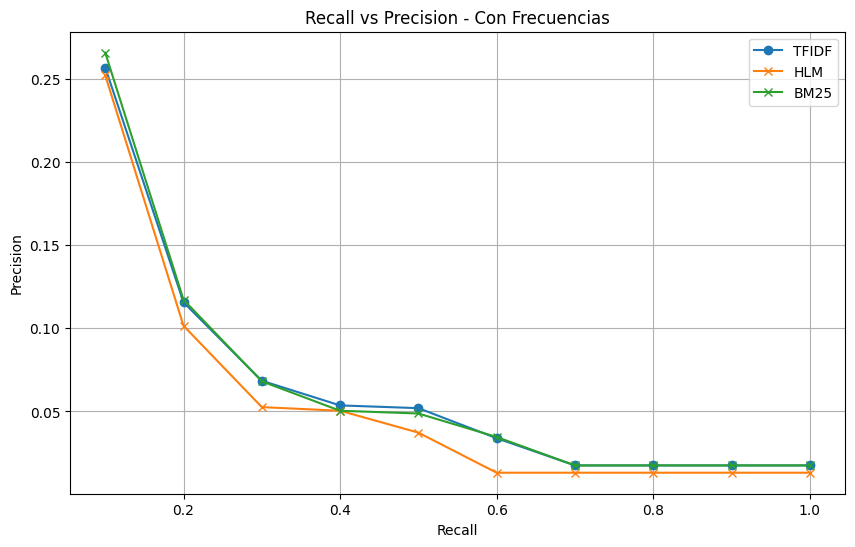

In [127]:
# Crear el gráfico de líneas
plt.figure(figsize=(10, 6))  # Establecer el tamaño del gráfico
plt.plot(df_11puntos_tfidf['Recall'], df_11puntos_tfidf['Precision'], marker='o', linestyle='-', label='TFIDF')  # Graficar Recall vs Precision
plt.plot(df_11puntos_tfidf['Recall'], df_11puntos_hlm['Precision'], marker='x', linestyle='-', label='HLM')  # Graficar Recall vs Precision
plt.plot(df_11puntos_bm25['Recall'], df_11puntos_bm25['Precision'], marker='x', linestyle='-', label='BM25')  # Graficar Recall vs Precision
plt.title('Recall vs Precision - Con Frecuencias')  # Establecer el título del gráfico
plt.xlabel('Recall')  # Etiqueta del eje x
plt.ylabel('Precision')  # Etiqueta del eje y
plt.grid(True)  # Activar la cuadrícula en el gráfico
plt.legend()  # Mostrar leyenda
plt.show()  # Mostrar el gráfico

In [129]:
## Queries sin Frec

# Ejecutar el experimento solo para el sistema TF-IDF
resultados_tfidf_sin_frecs = pt.Experiment(
    [tf_idf],
    queries_sin_frec,
    qrels,
    eval_metrics=eval_metrics,
    names=["TF_IDF"]
)

resultados_hlm_sin_frecs = pt.Experiment(
    [hlm],
    queries_sin_frec,
    qrels,
    eval_metrics=eval_metrics,
    names=["Hiemstra_LM"]
)

resultados_bm25_sin_frecs = pt.Experiment(
    [bm25],
    queries_sin_frec,
    qrels,
    eval_metrics=eval_metrics,
    names=["BM25"]
)


In [130]:
df_11puntos_sin_frec_tfidf = resultados_tfidf_sin_frecs.melt(value_vars=["iprec_at_recall_0.10", "iprec_at_recall_0.20", "iprec_at_recall_0.30", 
                                    "iprec_at_recall_0.40", "iprec_at_recall_0.50", "iprec_at_recall_0.60", 
                                    "iprec_at_recall_0.70", "iprec_at_recall_0.80", "iprec_at_recall_0.90", 
                                    "iprec_at_recall_1.00"], var_name="Recall", value_name="Precision")

df_11puntos_sin_frec_tfidf['Recall'] = df_11puntos_sin_frec_tfidf['Recall'].apply(lambda x: float(x.split('_')[-1]))

df_11puntos_sin_frec_bm25 = resultados_bm25_sin_frecs.melt(value_vars=["iprec_at_recall_0.10", "iprec_at_recall_0.20", "iprec_at_recall_0.30", 
                                    "iprec_at_recall_0.40", "iprec_at_recall_0.50", "iprec_at_recall_0.60", 
                                    "iprec_at_recall_0.70", "iprec_at_recall_0.80", "iprec_at_recall_0.90", 
                                    "iprec_at_recall_1.00"], var_name="Recall", value_name="Precision")

df_11puntos_sin_frec_bm25['Recall'] = df_11puntos_sin_frec_bm25['Recall'].apply(lambda x: float(x.split('_')[-1]))


df_11puntos_sin_frec_hlm = resultados_hlm_sin_frecs.melt(value_vars=["iprec_at_recall_0.10", "iprec_at_recall_0.20", "iprec_at_recall_0.30", 
                                    "iprec_at_recall_0.40", "iprec_at_recall_0.50", "iprec_at_recall_0.60", 
                                    "iprec_at_recall_0.70", "iprec_at_recall_0.80", "iprec_at_recall_0.90", 
                                    "iprec_at_recall_1.00"], var_name="Recall", value_name="Precision")

df_11puntos_sin_frec_hlm['Recall'] = df_11puntos_sin_frec_hlm['Recall'].apply(lambda x: float(x.split('_')[-1]))



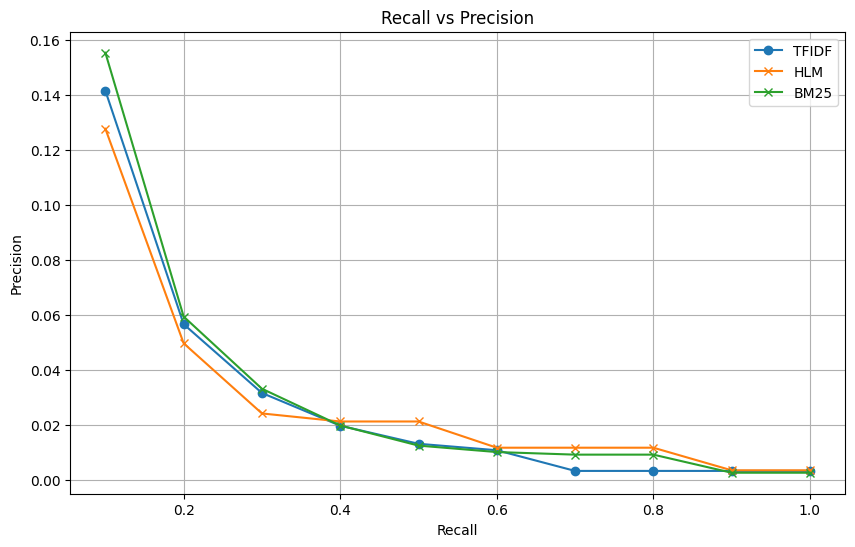

In [131]:
# Crear el gráfico de líneas
plt.figure(figsize=(10, 6))  # Establecer el tamaño del gráfico
plt.plot(df_11puntos_sin_frec_tfidf['Recall'], df_11puntos_sin_frec_tfidf['Precision'], marker='o', linestyle='-', label='TFIDF')  # Graficar la primera línea
plt.plot(df_11puntos_sin_frec_hlm['Recall'], df_11puntos_sin_frec_hlm['Precision'], marker='x', linestyle='-', label='HLM')  # Graficar la segunda línea
plt.plot(df_11puntos_sin_frec_bm25['Recall'], df_11puntos_sin_frec_bm25['Precision'], marker='x', linestyle='-', label='BM25')  # Graficar la segunda línea
plt.title('Recall vs Precision')  # Establecer el título del gráfico
plt.xlabel('Recall')  # Etiqueta del eje x
plt.ylabel('Precision')  # Etiqueta del eje y
plt.grid(True)  # Activar la cuadrícula en el gráfico
plt.legend()  # Mostrar leyenda
plt.show()  # Mostrar el gráfico

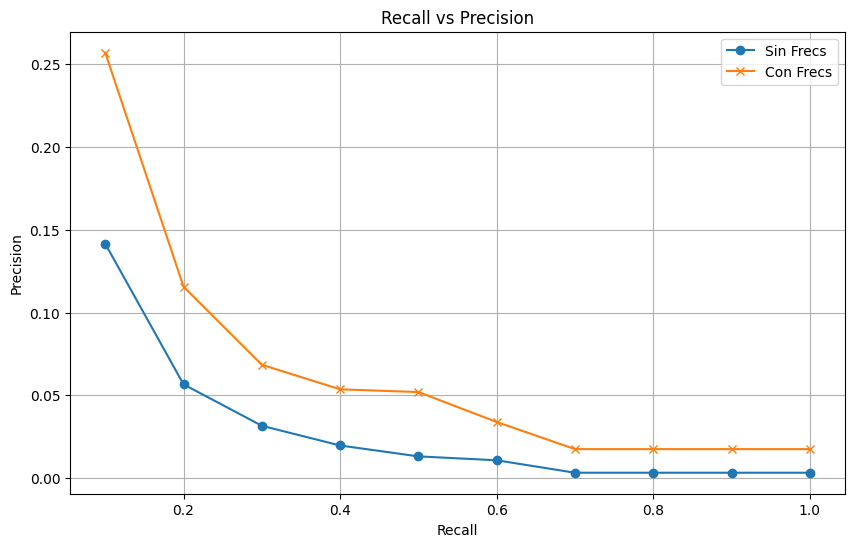